In [2]:
from pathlib import Path
import pickle

import torch
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.patches as patches
from matplotlib.collections import LineCollection

from datasets_utils import ds_load, ds_get_info

from push import find_high_activation_crop

import matplotlib.colors as mcolors

In [3]:
DATASETS_PATH = Path('datasets')
COLOR_CYCLE = ['#606060', '#AAAAAA', '#BBBBBB']

pickled_dses_file = './datasets.pickle'
if os.path.exists(pickled_dses_file):
    with open(pickled_dses_file, 'rb') as f:
        all_ds = pickle.load(f)
else:
    all_ds = ds_load(DATASETS_PATH, list(ds_get_info().keys()))
    with open(pickled_dses_file, 'wb') as f:
        pickle.dump(all_ds, f)


In [340]:
def get_latest_model(exp_name):
    experiment_dir = Path(f'experiments/{exp_name}/').absolute()
    if os.path.isdir(experiment_dir / 'saved_models'):
        parent_dir = experiment_dir / 'saved_models'
        saved_models = [m for m in parent_dir.iterdir() if 'nopush' not in m.name]  # only get models after pushing
        saved_models = sorted(saved_models, key=lambda m: m.stat().st_mtime)
        return saved_models[-1]
    else:
        return experiment_dir / 'models' / 'last-epoch.pth'

def latest_epoch(exp_name):
    parent_dir = Path(f'experiments/{exp_name}/protos/')
    if not parent_dir.exists() or not any(parent_dir.iterdir()):
        return None
    latest_subdir = sorted(parent_dir.iterdir(), key=lambda d: d.stat().st_mtime)[-1]
    return latest_subdir.name.replace('epoch-', '')

def plot_single_feature(ax, y, rf_start, rf_end, color):
    x = range(len(y))
    
    if rf_start > 0:
        ax.plot(x[:rf_start+1], y[:rf_start+1], color=color)
    line, = ax.plot(x[rf_start:rf_end], y[rf_start:rf_end], color=color)
    if rf_end < len(y):
        ax.plot(x[rf_end-1:], y[rf_end-1:], color=color)
    return line

def visualize_proto(ts, proto_range, ax=None, proto_bg='#c1d1f077', y_lim=None):
    if ax is None:
        _, ax = plt.subplots()
    lines = []
    labels = []

    rf_start = proto_range[0]
    rf_end = proto_range[1]

    default_color_cycle = COLOR_CYCLE
    for i, feat in enumerate(range(ts.shape[0])):
        lines.append(plot_single_feature(ax, ts[feat], rf_start, rf_end, feat_importance=1, color=default_color_cycle[i%len(default_color_cycle)]))
        labels.append(f'Feature {feat}')
    ax.set_xlim(0, ts.shape[1]-1)
    y_min_max = (np.min(ts[:, :-1]), np.max(ts[:, :-1]))
    y_range = y_min_max[1] - y_min_max[0]
    if y_lim is None:
        ax.set_ylim(y_min_max[0] - 0.2*y_range, y_min_max[1] + 0.2*y_range)
    else:
        ax.set_ylim(y_lim)
    y_lim = ax.get_ylim()
    ax.fill_between(range(rf_start, rf_end), *ax.get_ylim(), color=proto_bg) #, alpha=0.5)
    ax.set_ylim(y_lim)

In [7]:
dataset = all_ds['Libras']

exp_name = 'PrototypesTests/Libras'
latest_model = get_latest_model(exp_name)
savedir = Path.cwd()

experiment_dir = Path(f'experiments/{exp_name}/').absolute()
ptsnet = torch.load(latest_model, map_location=torch.device('cpu'))
ll_weight = ptsnet.last_layer.weight.to_dense().t() if ptsnet.last_layer.weight.is_sparse else ptsnet.last_layer.weight

0 (0, 0)
Predicted: 0
Actual: 0
Most activated 10 prototypes of this image:
top 3 activated prototype for this image:
prototype index: 1
prototype class identity: 0
activation value (similarity score): 1.4100792407989502
last layer connection with predicted class: 1.8605467081069946
most highly activated patch of the chosen image by this prototype:
(22, 36)
0 (0, 0)
Predicted: 0
Actual: 0
Most activated 10 prototypes of this image:
top 2 activated prototype for this image:
prototype index: 1
prototype class identity: 0
activation value (similarity score): 3.0805275440216064
last layer connection with predicted class: 1.8605467081069946
most highly activated patch of the chosen image by this prototype:
(22, 36)
0 (0, 0)
Predicted: 0
Actual: 0
Most activated 10 prototypes of this image:
top 1 activated prototype for this image:
prototype index: 1
prototype class identity: 0
activation value (similarity score): 2.1660754680633545
last layer connection with predicted class: 1.8605467081069

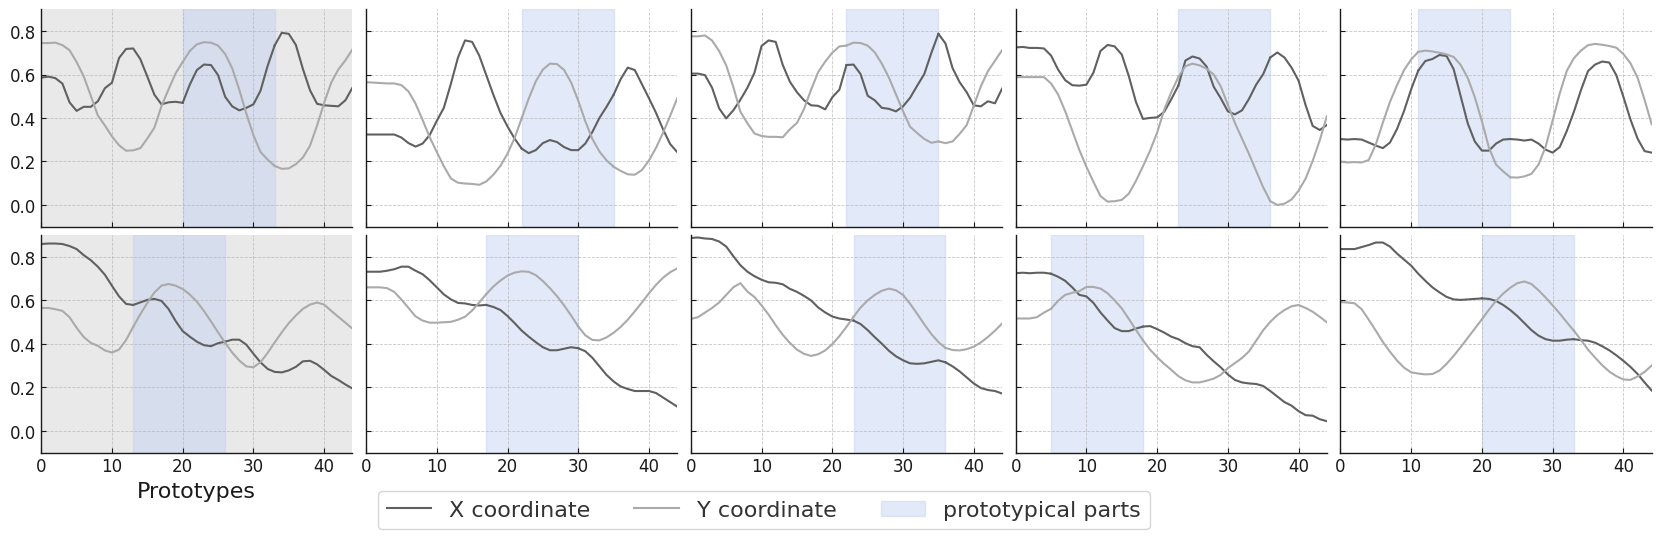

In [334]:
plt.rcParams.update({'font.size': 16})

ex_indices = [1, 3, 10, 6]
proto_num = 1

proto_bg = '#c1d1f077'

epoch_number_str = str(200)
prototype_info = np.load(os.path.join(Path(f'experiments/{exp_name}/protos').absolute(), 'epoch-'+epoch_number_str, 'bounds'+epoch_number_str+'.npy'))
prototype_img_identity = prototype_info[:, -1]

fig, axs = plt.subplots(2, len(ex_indices)+1, figsize=(3.3*(len(ex_indices)+1), 5), constrained_layout=True)

proto = np.load(f'experiments/{exp_name}/protos/epoch-{epoch_number_str}/prototype-ts-original_with_self_act{proto_num:03d}.npy')
receptive_field_size = 13 + ptsnet.prototype_shape[2] - 1
max_activation_idx = np.argmax(proto[:, -1])
rf_start = max_activation_idx - receptive_field_size // 2
rf_start = 0 if rf_start < 0 else rf_start
rf_end = rf_start + receptive_field_size + 1
rf_end = proto.shape[0] if rf_end > proto.shape[0] else rf_end
visualize_proto(proto[:, :-1].transpose()[::-1], (rf_start, rf_end), ax=axs[0, 0], y_lim=(-0.1, 0.9), proto_bg=proto_bg)
axs[0, 0].set_facecolor('#e9e9e9')
axs[0, 0].label_outer()

for ax_idx, ex_idx in enumerate(ex_indices, start=1):
    ex_npy = dataset.test.X[ex_idx]
    ex = torch.tensor([ex_npy])
    ex_label = dataset.test.y[ex_idx]

    logits, min_distances = ptsnet(ex)
    conv_output, distances = ptsnet.push_forward(ex)
    prototype_activations = ptsnet.distance_2_similarity(min_distances)
    prototype_activation_patterns = ptsnet.distance_2_similarity(distances)

    tables = []
    for i in range(logits.size(0)):
        tables.append((torch.argmax(logits, dim=1)[i].item(), ex_label))
        print(str(i) + ' ' + str(tables[-1]))

    idx = 0
    predicted_cls = tables[idx][0]
    correct_cls = tables[idx][1]
    print('Predicted: ' + str(predicted_cls))
    print('Actual: ' + str(correct_cls))

    print('Most activated 10 prototypes of this image:')
    array_act, sorted_indices_act = torch.sort(prototype_activations[idx])
    for i in range(1,4):
        if sorted_indices_act[-i].item() != proto_num:
            continue
        print(f'top {i} activated prototype for this image:')
        print('prototype index: {0}'.format(sorted_indices_act[-i].item()))
        print('prototype class identity: {0}'.format(prototype_img_identity[sorted_indices_act[-i].item()]))
        print('activation value (similarity score): {0}'.format(array_act[-i]))
        print('last layer connection with predicted class: {0}'.format(ptsnet.last_layer.weight[predicted_cls][sorted_indices_act[-i].item()]))
        
        activation_pattern = prototype_activation_patterns[idx][sorted_indices_act[-i].item()].detach().cpu().numpy()
        
        # show the most highly activated patch of the image by this prototype
        high_act_patch_indices = find_high_activation_crop(activation_pattern, proto_len=ptsnet.prototype_shape[2], ts_len=ex.shape[2])
        print('most highly activated patch of the chosen image by this prototype:')
        print(high_act_patch_indices)
        visualize_proto(ex_npy[::-1], high_act_patch_indices, ax=axs[0, ax_idx], y_lim=(-0.1, 0.9), proto_bg=proto_bg)
        axs[0, ax_idx].label_outer()

ex_indices = [146, 150, 153, 152]
proto_num = 13

proto_bg = '#c1d1f077'

epoch_number_str = str(200)
prototype_info = np.load(os.path.join(Path(f'experiments/{exp_name}/protos').absolute(), 'epoch-'+epoch_number_str, 'bounds'+epoch_number_str+'.npy'))
prototype_img_identity = prototype_info[:, -1]

proto = np.load(f'experiments/{exp_name}/protos/epoch-{epoch_number_str}/prototype-ts-original_with_self_act{proto_num:03d}.npy')
receptive_field_size = 13 + ptsnet.prototype_shape[2] - 1
max_activation_idx = np.argmax(proto[:, -1])
rf_start = max_activation_idx - receptive_field_size // 2
rf_start = 0 if rf_start < 0 else rf_start
rf_end = rf_start + receptive_field_size + 1
rf_end = proto.shape[0] if rf_end > proto.shape[0] else rf_end
visualize_proto(proto[:, :-1].transpose()[::-1], (rf_start, rf_end), ax=axs[1, 0], y_lim=(-0.1, 0.9), proto_bg=proto_bg)
axs[1, 0].set_facecolor('#e9e9e9')
axs[1, 0].set_xlabel('Prototypes')

for ax_idx, ex_idx in enumerate(ex_indices, start=1):
    ex_npy = dataset.test.X[ex_idx]
    ex = torch.tensor([ex_npy])
    ex_label = dataset.test.y[ex_idx]

    logits, min_distances = ptsnet(ex)
    conv_output, distances = ptsnet.push_forward(ex)
    prototype_activations = ptsnet.distance_2_similarity(min_distances)
    prototype_activation_patterns = ptsnet.distance_2_similarity(distances)

    tables = []
    for i in range(logits.size(0)):
        tables.append((torch.argmax(logits, dim=1)[i].item(), ex_label))
        print(str(i) + ' ' + str(tables[-1]))

    idx = 0
    predicted_cls = tables[idx][0]
    correct_cls = tables[idx][1]
    print('Predicted: ' + str(predicted_cls))
    print('Actual: ' + str(correct_cls))

    print('Most activated 10 prototypes of this image:')
    array_act, sorted_indices_act = torch.sort(prototype_activations[idx])
    for i in range(1,4):
        if sorted_indices_act[-i].item() != proto_num:
            continue
        print(f'top {i} activated prototype for this image:')
        print('prototype index: {0}'.format(sorted_indices_act[-i].item()))
        print('prototype class identity: {0}'.format(prototype_img_identity[sorted_indices_act[-i].item()]))
        print('activation value (similarity score): {0}'.format(array_act[-i]))
        print('last layer connection with predicted class: {0}'.format(ptsnet.last_layer.weight[predicted_cls][sorted_indices_act[-i].item()]))
        
        activation_pattern = prototype_activation_patterns[idx][sorted_indices_act[-i].item()].detach().cpu().numpy()

        # show the most highly activated patch of the image by this prototype
        high_act_patch_indices = find_high_activation_crop(activation_pattern, proto_len=ptsnet.prototype_shape[2], ts_len=ex.shape[2])
        print('most highly activated patch of the chosen image by this prototype:')
        print(high_act_patch_indices)
        visualize_proto(ex_npy[::-1], high_act_patch_indices, ax=axs[1, ax_idx], y_lim=(-0.1, 0.9), proto_bg=proto_bg)
        axs[1, ax_idx].label_outer()

fig.legend([axs[1, 0].lines[3*i] for i in range(2)] + [patches.Patch(color=proto_bg, label='prototypes')], ['X coordinate', 'Y coordinate'] + ['prototypical parts'],
           bbox_to_anchor=(0.7, 0.05), ncols=3)
fig.savefig('libras_proto_with_examples.pdf', bbox_inches='tight')


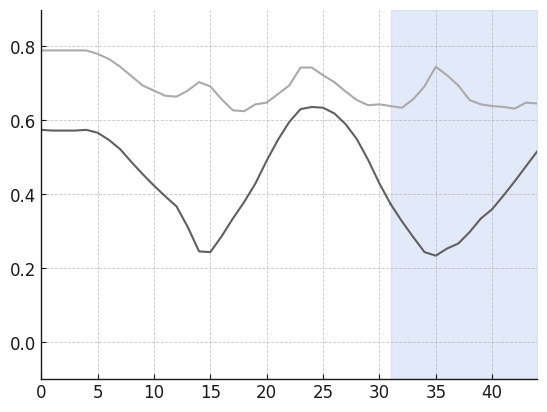

In [343]:
plt.rcParams.update({'font.size': 14})

ex_indices = [9]
proto_num = 2

proto_bg = '#c1d1f077'

epoch_number_str = str(200)
prototype_info = np.load(os.path.join(Path(f'experiments/{exp_name}/protos').absolute(), 'epoch-'+epoch_number_str, 'bounds'+epoch_number_str+'.npy'))
prototype_img_identity = prototype_info[:, -1]

proto = np.load(f'experiments/{exp_name}/protos/epoch-{epoch_number_str}/prototype-ts-original_with_self_act{proto_num:03d}.npy')
receptive_field_size = 13 + ptsnet.prototype_shape[2] - 1

rf_start, rf_end = find_high_activation_crop(proto[:, -1], proto_len=ptsnet.prototype_shape[2], ts_len=ex.shape[2])
visualize_proto(proto[:, :-1].transpose(), (rf_start, rf_end), y_lim=(-0.1, 0.9), proto_bg=proto_bg)
plt.savefig(f'libras_proto_{proto_num}.pdf')

for ax_idx, ex_idx in enumerate(ex_indices, start=1):
    ex_npy = dataset.test.X[ex_idx]
    ex = torch.tensor([ex_npy])
    ex_label = dataset.test.y[ex_idx]

    logits, min_distances = ptsnet(ex)
    conv_output, distances = ptsnet.push_forward(ex)
    prototype_activations = ptsnet.distance_2_similarity(min_distances)
    prototype_activation_patterns = ptsnet.distance_2_similarity(distances)

    tables = []
    for i in range(logits.size(0)):
        tables.append((torch.argmax(logits, dim=1)[i].item(), ex_label))
        print(str(i) + ' ' + str(tables[-1]))

    idx = 0
    predicted_cls = tables[idx][0]
    correct_cls = tables[idx][1]
    print('Predicted: ' + str(predicted_cls))
    print('Actual: ' + str(correct_cls))

    max_protos = 3
    print(f'Most activated {max_protos} prototypes of this image:')
    array_act, sorted_indices_act = torch.sort(prototype_activations[idx])
    for i in range(1, max_protos+1):
        print(f'top {i} activated prototype for this image:')
        print('prototype index: {0}'.format(sorted_indices_act[-i].item()))
        print('prototype class identity: {0}'.format(prototype_img_identity[sorted_indices_act[-i].item()]))
        print('activation value (similarity score): {0}'.format(array_act[-i]))
        print('last layer connection with predicted class: {0}'.format(ptsnet.last_layer.weight[predicted_cls][sorted_indices_act[-i].item()]))
        
        activation_pattern = prototype_activation_patterns[idx][sorted_indices_act[-i].item()].detach().cpu().numpy()
        
        # show the most highly activated patch of the image by this prototype
        high_act_patch_indices = find_high_activation_crop(activation_pattern, proto_len=ptsnet.prototype_shape[2], ts_len=ex.shape[2])
        
        print('most highly activated patch of the chosen image by this prototype:')
        print(high_act_patch_indices)
        visualize_proto(ex_npy, high_act_patch_indices, y_lim=(-0.1, 0.9), proto_bg=proto_bg)

# fig.legend([axs[0].lines[3*i] for i in range(2)] + [patches.Patch(color=proto_bg, label='prototypes')], ['X coordinate', 'Y coordinate'] + ['prototypes'], loc='lower center', ncols=3) # (0.35, -0.05)
# fig.savefig('libras_proto_with_examples_1.pdf')

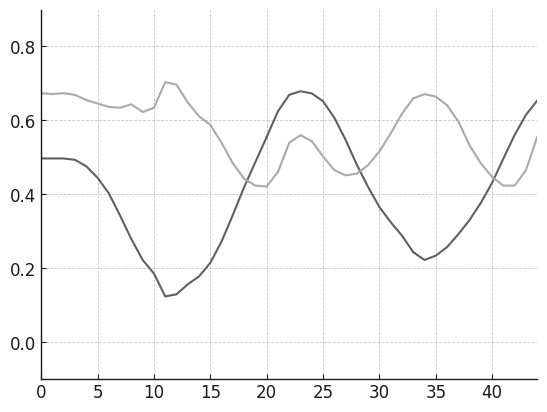

In [347]:
visualize_proto(ex_npy, high_act_patch_indices, y_lim=(-0.1, 0.9), proto_bg='#ffffff')
plt.savefig(f'libras_instance_9.pdf')

In [373]:
def generate_series(L, rf_start, rf_end, transition_length=4):
    series = np.zeros(L)
    for i in range(L):
        if rf_start <= i < rf_start + transition_length:
            series[i] = (i - rf_start) / transition_length
        elif rf_start + transition_length <= i < rf_end:
            series[i] = 1
        elif rf_end <= i < rf_end + transition_length:
            series[i] = 1 - (i - rf_end) / transition_length
        else:
            series[i] = 0
    return series

def plot_x_y_with_proto_activation(x, y, rf_indices, ax=None, colors=['#606060', 'orange']):
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    if ax is None:
        ax = plt.gca()

    rf_start = rf_indices[0]
    rf_end = rf_indices[1]

    x = np.linspace(0, 100, len(x))

    act = generate_series(len(segments), rf_start, rf_end)
    sort_indices = np.argsort(act)
    segments = segments[sort_indices]
    act = act[sort_indices]
    
    cmap = mcolors.LinearSegmentedColormap.from_list("custom_colormap", colors)
    
    # Create a continuous norm to map from data points to colors
    norm = plt.Normalize(act.min(), act.max())
    lc = LineCollection(segments, cmap=cmap, norm=norm)
    # Set the values used for colormapping
    lc.set_array(act)
    lc.set_linewidth(4)
    line = ax.add_collection(lc)
    ax.set_xlim(0,1)
    
    return line

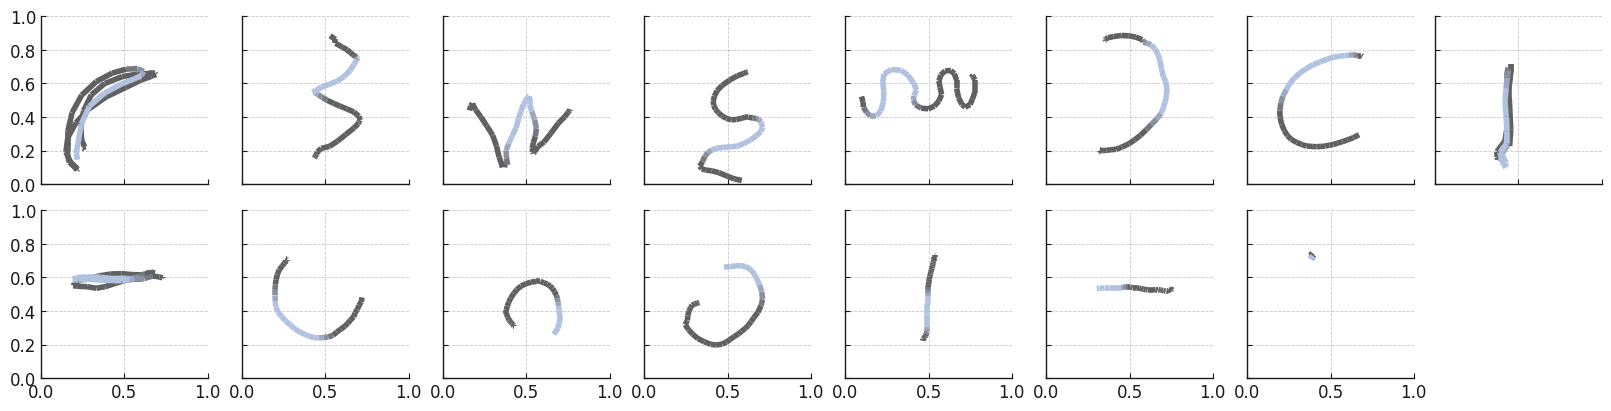

In [380]:
ex_idx = 8

ex_npy = dataset.test.X[ex_idx]
ex = torch.tensor([ex_npy])
ex_label = dataset.test.y[ex_idx]


fig, axs = plt.subplots(2, 8, figsize=(16, 4), constrained_layout=True)

protos_to_plot = [0, 3, 6, 9, 12, 15, 20, 21, 24, 27, 30, 33, 36, 39, 42]
for i, proto_idx in enumerate(protos_to_plot):
    ax = axs[i // 8, i % 8]
    ax.label_outer()
    proto = np.load(f'experiments/{exp_name}/protos/epoch-{epoch_number_str}/prototype-ts-original_with_self_act{proto_idx:03d}.npy')
    (rf_start, rf_end) = find_high_activation_crop(proto[:, -1], proto_len=ptsnet.prototype_shape[2], ts_len=ex.shape[2])

    line = plot_x_y_with_proto_activation(proto[:, 1], proto[:, 0], (rf_start, rf_end), ax=ax, colors=['#606060', '#b1c1e0'])

axs[1, 7].set_visible(False)
plt.show()

fig.savefig('libras_all_protos.pdf')